In [1]:
import sys
import os
import numpy as np
import time
from pathlib import Path
from matplotlib import pyplot as plt

import librosa
from librosa.display import specshow
from script.parameter_input import *

In [19]:
### input audio and load model

#test_path = sys.argv[1]
test_path = os.path.join('..', 'tiny_data', '7383-3-0-0.wav')

In [27]:
### preprocessor 
class Audio_Preprocessor:
    """
    audio preprocessor
    
    transform_to_Sdb: transform audio into numpy array with two channels
    
    slice_train: slice train audio array into fixed size window
    
    slice_test: slice test audio array into fixed size window
    
    
    """

    def __init__(self,
                 hops_per_sec=HOPS_PER_SEC,
                 sp_rt=SAMPLING_RATE,
                 hop_len=int(SAMPLING_RATE / HOPS_PER_SEC),
                 n_mels=N_MELS,
                 offset=OFFSET,
                 duration=WIN_SEC):
        self.hops_per_sec = hops_per_sec
        self.sp_rt = sp_rt
        self.hop_len = hop_len
        self.n_mels = n_mels
        self.offset = offset
        self.duration = duration
        self.width = self.duration * self.hops_per_sec

    def transform_to_Sdb(self, aud_file):

        self.stem = Path(aud_file).stem

        mp3, sr = librosa.load(aud_file, sr=self.sp_rt, mono = False)
        total_time = librosa.samples_to_time(len(mp3), self.sp_rt)
        
        S0 = librosa.feature.melspectrogram(
            y=mp3[0,:], sr=self.sp_rt, n_mels=self.n_mels, hop_length=self.hop_len)
        S1 = librosa.feature.melspectrogram(
            y=mp3[1,:], sr=self.sp_rt, n_mels=self.n_mels, hop_length=self.hop_len)
        S = np.dstack([S0, S1])

        self.S_db = librosa.power_to_db(S, ref=np.max)
        self.S_db = np.swapaxes(self.S_db, 0, 1)
        
            
        print(f'audio {self.stem} total {total_time} seconds, with S_db shape {self.S_db.shape}')
        
    
    def slice_train(self, save = True):
        S_db_scale = self.S_db/-80  # normalize into range [0, 1]
        n, m, k = S_db_scale.shape  # m = N_MELS
        
        resx_train = []
        for i in range(0, n - self.width + 1, 5): # 5 hops ahead overlapping
            X = S_db_scale[i:self.width + i, :, :]
            resx_train.append(X)
            
        self.train_array = np.stack(resx_train)
        
        if save:
            np.save(os.path.join('..', 'npy', f'{self.stem}.npy'), self.train_array)
            
        print(f'split audio {self.stem}.wav for training with shape: {self.train_array.shape}')
        
    
    def slice_test(self):

        S_db_scale = self.S_db/-80 # normalize into range [0, 1]
        n, m, k = S_db_scale.shape  # m = N_MELS
        
        resx_test = []
        for i in range(0, n, self.width): # non-overlapping for test
            x = S_db_scale[i:i+self.width, :, :]
            left = self.width - x.shape[0]
            if left > 0:
                x = S_db_scale[i-left:, :, :]
            resx_test.append(x)
            
        self.test_array = np.stack(resx_test)
        print(f'split audio {self.stem}.wav for testing with shape: {self.test_array.shape}')
        

In [28]:
ap = Audio_Preprocessor()
ap.transform_to_Sdb(test_path)

audio 7383-3-0-0 total 4.5351473922902495e-05 seconds, with S_db shape (81, 16, 2)


In [29]:
ap.slice_train() # save into npy folder

split audio 7383-3-0-0.wav for training with shape: (5, 60, 16, 2)


In [30]:
ap.train_array[0].shape

(60, 16, 2)

In [31]:
# try to load npy from folder

test = np.load(os.path.join('..', 'npy', '7383-3-0-0.npy'))
test.shape

(5, 60, 16, 2)

In [16]:
# visualize mel spectrogram

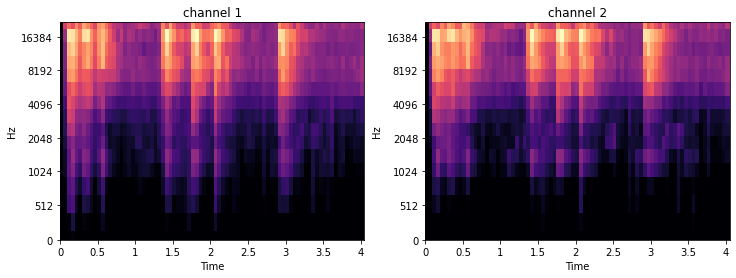

In [32]:
def vis_array(Sdb):
    fig, axes = plt.subplots(figsize=(12, 4), nrows = 1 , ncols = 2)
    ax1, ax2 = axes.flatten()

    img = specshow(np.rot90(Sdb[:, :, 0]), x_axis='time', y_axis='mel',
                ax=ax1, sr=SAMPLING_RATE, hop_length=HOP_LENGTH)

    ax1.set_title(f'channel 1')


    img = specshow(np.rot90(Sdb[:, :, 1]), x_axis='time', y_axis='mel',
                ax=ax2, sr=SAMPLING_RATE, hop_length=HOP_LENGTH)

    ax2.set_title(f'channel 2')

    plt.show()
    
vis_array(ap.S_db)